<a href="https://colab.research.google.com/github/Martinmbiro/PyTorch-workflow/blob/main/03%20Training%20and%20evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Training**
> In the previous notebook when we performed inferencing using the method, the values we got were erronious since the `weight` and `bias` _parameters_ were randomly instantiated

> Training is needed to better map the _parameters_ to the data

In [ ]:
# import
import torch, matplotlib.pyplot as plt
# specify style sheet to use
plt.style.use('fast')

torch.__version__

'2.5.1+cu121'

In [ ]:
# set up device
if torch.cuda.is_available():
  device = 'cuda'
elif torch.backends.mps.is_available():
  device= 'mps'
else:
  device = 'cpu'

### Creating data using the linear regression formula
> Recall the linear regression formula  
+ We'll use known parameters for `m` and `c` as `weight` and `bias` respectively, to map the input, `X` to the output `y`

```
    y = mX + c

```

In [ ]:
# create known parameters
weight = 0.7
bias = 0.3

> ✋ **Info**  
+ We'll use [`torch.arange()`](https://pytorch.org/docs/stable/generated/torch.arange.html#torch-arange) to generate values between `0` and `1` with a step of `0.02` between values
+ [`Tensor.unsqueeze()`](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html#torch.unsqueeze) will add a dimension of size `1` at position `1` so that we have n _rows_, but `1` _column_ for the entire data

In [ ]:
# create data, input and target
# input
X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)

# output
y = weight * X + bias

In [ ]:
# check shape of data
print(f'Input shape: {y.shape}')
print(f'Output shape: {X.shape}')

Input shape: torch.Size([50, 1])
Output shape: torch.Size([50, 1])


In [ ]:
# visualize data (first 5 values for X and y)
print(X[:, 0][:5])
print(y[:, 0][:5])

tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800])
tensor([0.3000, 0.3140, 0.3280, 0.3420, 0.3560])


#### Splitting data into train and validation sets
> ✋ **Info**

> It is common practice to use 80% of a dataset for training and 20% for validation.
+ We'll do that using a slicing index
+ Alternatively, we could split by _filtering_ the tensor based on [`torch.Tensor.quantile()`](https://pytorch.org/docs/stable/generated/torch.Tensor.quantile.html#torch-tensor-quantile)

In [ ]:
# define a slicing index:
train_split = round(0.8*len(X))

# split into training and validation sets
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# size
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
# define a function to plot train, test and predicted values
def plot_predictions(X_test=X_test, X_train=X_train,
                     y_train=y_train, y_test=y_test, y_preds=None):
  # can't plot on the GPU, hence if any of the values are on
  # GPU, move them to CPU and proceed
  if X_test.device != 'cpu':
    X_test = X_test.cpu().numpy()
    X_train = X_train.cpu().numpy()
    y_test = y_test.cpu().numpy()
    y_train = y_train.cpu().numpy()
    if y_preds is not None:
      y_preds = y_preds.cpu().numpy()

  _, ax = plt.subplots(figsize=(5, 3.5), layout='constrained')
  # train data
  ax.scatter(x=X_train, y=y_train, s=4.5, c='#007fff',
            label='Train Data')
  # test data
  ax.scatter(x=X_test, y=y_test, s=3.0, c='#ab274f',
            label='Test Data')
  # preds
  if y_preds is not None:
    ax.scatter(x=X_test, y=y_preds, c='black',
              marker='*', label='y_preds')

  ax.tick_params(axis='both', labelsize=9)
  ax.set_ylabel('Target (y)')
  ax.set_xlabel('Input (X)')
  ax.set_title('Target values (y) vs Input values (X)',
              weight='black', fontsize=11)

  plt.legend(loc='upper right', fancybox=False,
             fontsize=9,
            bbox_to_anchor=(1.41, 1.025))
  plt.show()

In [ ]:
# define a function to plot training results
def plot_train_results(ep_count:list, eval_loss:list, train_loss:list):
  _, ax = plt.subplots(figsize=(5, 3), layout='constrained')
  # train loss
  ax.plot(ep_count, train_loss, color='#ab274f', linestyle='-',
          linewidth=2.0, label='Training loss')

  # eval_loss
  ax.plot(ep_count, eval_loss, color='#0047ab', linestyle='--',
          linewidth=2.0, label='Eval loss')

  # ticks, labels, title
  ax.tick_params(axis='both', labelsize=9)
  ax.set_title('Training and Validation Loss across Epochs',
              weight='black')
  ax.set_ylabel('Loss (Mean Absolute Error)')
  ax.set_xlabel('Epoch')

  plt.grid(color='#e5e4e2')
  _.legend(loc='upper right', fancybox=False,
           fontsize=9, bbox_to_anchor=(1.27, 0.931))

  plt.show()

### Build linear regression model
> 📝 **Note**  

> Recall the linear regression formula, `y = mX + c`  
> In our case,
+ `y`- Predicted output
+ `m` - `weight'
+ `c` - `bias`

In [ ]:
from torch import nn
# linear regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1))
    self.bias = nn.Parameter(torch.randn(1))

  def forward(self, x):
    # m * x + c
    return self.weight * x + self.bias

In [ ]:
# for consistent results
torch.manual_seed(42)

# instantiate the model class
model_1 = LinearRegressionModel().to(device=device)

# print model parameters
for key, val in model_1.state_dict().items():
  print(key, val)


weight tensor([0.3367], device='cuda:0')
bias tensor([0.1288], device='cuda:0')


### [`Loss function`](https://pytorch.org/docs/stable/nn.html#loss-functions) and [`optimizer`](https://pytorch.org/docs/stable/optim.html#algorithms)
> 📝 **Note**  
+ **Loss function** - A function that measures how wrong the model predictions (`y_preds`) are compared to the ground truth (`y_test`) data
>> + For this example, we'll use [`nn.L1Loss(y_pred, y_train)`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss) that calculates Mean Absolute Error
+ **Optimizer** - An algorithm that updates the _parameters_ of a neural network to minimize the given _loss_ calculated by the loss function, through **gradient descent**
>> + Here, we'll use [`torch.optim.SGD(params, lr)`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)  
>> + Usually, we optimize a model's _parameters_ hence they are passed as the first argument to an optimizer, followed by the learning rate

In [ ]:
# instantiate loss function
loss_fn = nn.L1Loss()

# optimizer
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.01)

### Optimization loop
> The next step is to create a training / testing loop.

> 📝 **Note**  
> Inside the loop, we'll have the following operations:  
1. Turn on training mode - calling [`model_1.train()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.train)
2. Forward pass through the model - `model_1(X_train)`
3. Calculate loss - by calling `loss_fn(y_preds, y_train)`
4. Back-propagation - by calling `loss.backward()`
5. Step the optimizer - perform gradient descent by calling [`optimizer.step()`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html#torch-optim-optimizer-step)
6. Zero-grad - clear the gradients of all optimized parameters by calling [`optimizer.zero_grad()`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html#torch-optim-optimizer-zero-grad)
7. Turn on evaluation mode - calling [`model_1.eval()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval)
8. Evaluate the model

In [ ]:
# put data on available device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
%%time
torch.manual_seed(42)

# epoch
# (the number of times the data passes through the model)
epochs = 201

# lists to store epoch, train & eval loss
ep_count, train_loss, eval_loss = list(), list(), list()

for ep in range(epochs):
  ep_count.append(ep)

  # 1. turn on training mode
  model_1.train()
  # 2. forward pass
  y_pred = model_1(X_train)

  # 3. calculate loss
  tr_ls = loss_fn(y_pred, y_train)
  train_loss.append(tr_ls.item())

  # 4. back-propagate
  tr_ls.backward()
  # 5. step optimizer
  optimizer.step()
  # 6. zero grad
  optimizer.zero_grad()


  # 7. turn on evaluation mode
  model_1.eval()

  # 8. evaluate model
  with torch.inference_mode():
    x_pred = model_1(X_test)

    ts_ls = loss_fn(x_pred, y_test)
    eval_loss.append(ts_ls.item())

CPU times: user 218 ms, sys: 46.6 ms, total: 264 ms
Wall time: 432 ms


### Model Evaluation
> Here's we'll evaluate our model by:
+ Visualizing the loss (Mean Absolute Error) calculated by our chosen loss function [`nn.L1Loss`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss)
+ Comparing the final learnt parameters to the original hand-coded `weight` and `bias` variables
+ Visualizing and comparing the predicted values to the expected predictions based on the hand-coded `weight` and `bias`

In [ ]:
# print initial hard coded parameters
print(f'Initial weight: {weight}\nInitial bias: {bias}\n')

# versus learnt parameters
model_1.state_dict()

Initial weight: 0.7
Initial bias: 0.3



OrderedDict([('weight', tensor([0.6951], device='cuda:0')),
             ('bias', tensor([0.2993], device='cuda:0'))])

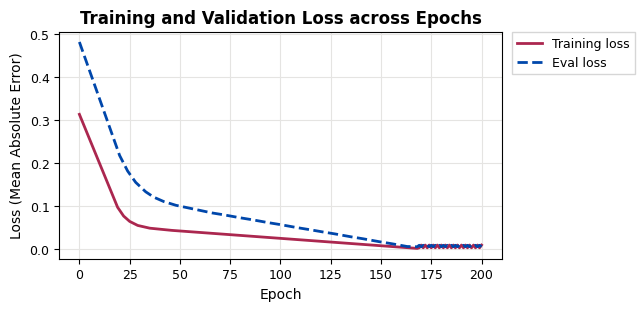

In [ ]:
# plot training results
plot_train_results(ep_count, eval_loss, train_loss)

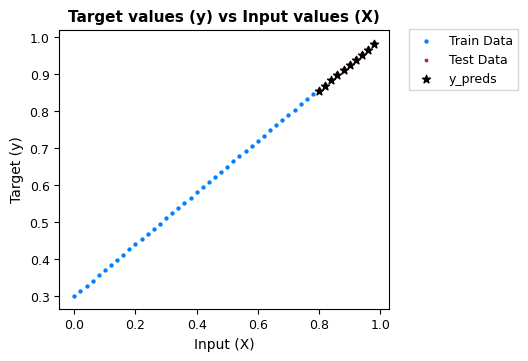

In [ ]:
# make predictions and compare them to expected predictions
with torch.inference_mode():
  y_preds = model_1(X_test)
  plot_predictions(y_preds=y_preds)

### Saving the model
> ✋ **Info**  

> The [official PyTorch documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) **recommends** saving and loading a model from the model's [`state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.state_dict)
+ The [`torch.save(obj, f)`](https://pytorch.org/docs/stable/generated/torch.save.html#torch-save) method saves a model's `state_dict`, `obj` to a disk file path `f`. This can be done right on Google Colab, and we can later download the model to the machine! 🎆
+ A commom convention is to save python models with a `.pt` or `.pth` file extension
+ We'll also use [`pathlib`](https://docs.python.org/3/library/pathlib.html) - a Python module that provides OOP interface for working with file system paths

In [ ]:
from pathlib import Path

# 1. create model directory
PARENT = Path('models')
PARENT.mkdir(parents=True, exist_ok=True)

# 2. model name, path
MODEL_NAME = 'regression_model_1_pytorch.pth'
MODEL_PATH = PARENT/MODEL_NAME

# 3. save model's state_dict
torch.save(model_1.to('cpu').state_dict(), MODEL_PATH)

#### Loading a saved model
> The procedure is as follows
+ Create an object of the original model class
+ Then call [`load_state_dict()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.load_state_dict) on the object
+ We'll then pass [`torch.load(f)`](https://pytorch.org/docs/stable/generated/torch.load.html#torch.load), where `f` is a path containing a previously saved model's `state_dict`  

> ❗ **Disclaimer**
+ You must call [`model.eval()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval) to set dropout and batch normalization layers to evaluation mode before running inference, otherwise, inconsistent inference results will be yielded

In [ ]:
# create an object of the model
loaded_model_1 = LinearRegressionModel()
loaded_model_1.state_dict()

OrderedDict([('weight', tensor([0.2345])), ('bias', tensor([0.2303]))])

In [ ]:
# load state_dict
loaded_model_1.load_state_dict(torch.load(f=MODEL_PATH, weights_only=True))
loaded_model_1.eval()

# check loaded state_dict for both models
print(loaded_model_1.state_dict())
print(model_1.state_dict())

OrderedDict([('weight', tensor([0.6951])), ('bias', tensor([0.2993]))])
OrderedDict([('weight', tensor([0.6951])), ('bias', tensor([0.2993]))])


In [ ]:
# create a random dataset
X_toy = torch.rand(5, 1)

# compare predictions: (results should be true)
model_1(X_toy) == loaded_model_1(X_toy)

tensor([[True],
        [True],
        [True],
        [True],
        [True]])

### Final thoughts
> Not too bad for a start, huh? However,   

> 📝 **Note**  

> This was an extremely simple example where we hand-coded the parameters and trained a model to learn the same. In real-world scenarios, the parameters are unknown
+ To avoid training to a point of [overfitting](https://www.datacamp.com/blog/what-is-overfitting#:~:text=Overfitting:%20High%20accuracy%20on%20training,t%20even%20navigate%20your%20hometown.), we'll implement [early_stopping](https://medium.com/@Coursesteach/deep-learning-part-38-data-augmentation-and-early-stopping-17e6298dba1a#:~:text=Prevent%20overfitting:%20By%20stopping%20training,generalization%20to%20new%2C%20unseen%20data.) in the next notebook (early stopping is just one of the ways to prevent overfitting)

> ▶️ **Up Next**

> A final simple regression project with [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), [`Dataloader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) and **early_stopping** implemented